In [1]:
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random
import glob
import time
from math import sqrt

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, mean_squared_error #, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier

In [3]:
import myFunctions
import myMLfunctions

# 1) Raw data

In [4]:
files = os.listdir(os.getcwd()+'/data/Output/')
df = [pd.read_csv(''.join([os.getcwd()+'/data/Output/',f])) for f in files]
df = pd.concat(df)
df = df.sort_values(by=['DATE'])
df = df.reset_index(drop=True)
df.shape

(13236, 24)

In [5]:
df.tail(100)

,DATE,COUNTRY,INDUSTRY,RET1M,SIZE,PE,PFCF,EVEBITDA,PB,DY,...,ROE,FCFROIC,VOL6M,BETA12M,NDE,NDEBITDA,SPSTSTAT,FCFROICTSTAT,DISPERSION,ACCTACF
13136,20220630,United States,Technology,11.637127,8.343171,12.636551,-4.070937,17.679429,101.316908,2.326501,...,12.472303,-3.170051,0.355427,0.955673,33.360357,142.885877,3.777693,1.198777,0.009958,1.144652
13137,20220630,United States,Industrials,17.662334,9.493685,5.489760,5.153806,8.112373,14.556753,1.754494,...,37.712807,14.537960,0.333999,0.985892,159.870634,232.713167,2.905049,0.021735,0.017603,-3.847408
13138,20220630,United States,Industrials,14.797187,11.378224,3.274230,3.065643,4.684083,4.797498,1.928204,...,68.248706,35.608155,0.292727,0.916603,42.374013,42.535312,11.696677,-0.021093,0.003967,-1.014506
13139,20220630,United States,Technology,25.796700,10.527159,1.331893,3.953604,2.094987,2.275473,0.000000,...,58.532564,42.481571,0.514800,1.617638,152.620422,160.205217,44.794071,1.535055,0.011668,-12.017242
13140,20220630,United States,Technology,14.345622,8.915556,17.008702,1.895145,18.967814,72.109699,0.000000,...,23.587260,1.716972,0.322115,0.996528,53.360364,145.659807,3.802282,1.242335,0.081187,3.539626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13231,20220729,United States,Industrials,-3.591311,9.648496,4.702402,4.414632,7.142257,12.468980,1.527363,...,37.712807,14.537960,0.352888,1.021419,159.870634,232.713167,2.905049,0.021735,0.019939,-3.847408
13232,20220729,United States,Consumer Services,-0.850564,10.641645,5.748669,6.347390,7.210896,-8.095375,0.000000,...,NaN,49.830602,0.342036,0.722626,NaN,237.912392,6.060645,-0.012402,0.009468,-9.287755
13233,20220729,United States,Industrials,1.364470,11.516220,2.852187,2.670487,4.090817,4.179108,1.750166,...,68.248706,35.608155,0.287670,0.946713,42.374013,42.535312,11.696677,-0.021093,0.021363,-1.014506
13234,20220729,United States,Telecommunications,-9.482569,12.175535,11.031791,7.759886,13.303431,43.179667,5.596449,...,25.548578,6.068094,0.228966,0.252528,211.396576,357.348994,0.762200,0.612774,0.006778,-4.615708


In [6]:
count_specific_value = (df['DATE'] == 20141231).sum()
count_specific_value

88

#### The features = the 20 columns with company fundamentals
#### The response = 1-month forward return
#### we need to pre-process these data to control for certain stat aspects and for the classification task ahead

# 2) Data pre-processing

### Features engineering (X)

In [7]:
# we will normalize the data with z-score. This is a standard procedure for company fundamentals
zscore = lambda x: (x - x.mean()) / x.std()

list_of_factors = [
    "SIZE",
    "PE",
    "PFCF",
    "EVEBITDA",
    "PB",
    "DY",
    "R12M1M",
    "IMOM12M1M",
    "UPDOWN6",
    "SUE6",
    "ROE",
    "FCFROIC",
    "VOL6M",
    "BETA12M",
    "NDE",
    "NDEBITDA",
    "SPSTSTAT",
    "FCFROICTSTAT",
    "DISPERSION",
    "ACCTACF",
]

P = df["DATE"] # just the vector of dates but repeated across the universe each month, i.e. not unique
G = df["DATE"].astype(str).str.cat(df["INDUSTRY"]) # a concatenated string with date and industry

X = df[list_of_factors].copy()

# trim factors between 2% and 98% (i.e. removing outliers)
# X.groupby(P) = for every feature (i.e. column) -> group by date, i.e. each month across the universe and clip the top and bottom 2%
X = X.groupby(P).transform(lambda x: x.clip(np.nan_to_num(x.quantile(0.02)), np.nan_to_num(x.quantile(0.98))))

# winsorize the data using z-scores and capping between -3 and 3 stds (you can increase the # of winsorization for more robustness)
# X.groupy(G) = a group is an industry at a specific month
number_of_winsorizations = 1
for i in range(number_of_winsorizations):
    X = X.groupby(G).transform(zscore)
    X = X.clip(-3, 3)

# for factors where lower value is better multiply z-score by -1
low_value_ranks_better_factors = [
    "SIZE",
    "VOL6M",
    "BETA12M",
    "NDE",
    "NDEBITDA",
    "DISPERSION",
    "ACCTACF",
]

X[low_value_ranks_better_factors] = -1 * X[low_value_ranks_better_factors]

# Only doing this to simplify some of the below examples
X = X.round(2)

X.shape

# so here we have taken out at each date the 2% tails of every feature (across all industries) and we have also winsorised the outlier per sector (sector neutral normalization and winsorization)

(13236, 20)

In [8]:
X

,SIZE,PE,PFCF,EVEBITDA,PB,DY,R12M1M,IMOM12M1M,UPDOWN6,SUE6,ROE,FCFROIC,VOL6M,BETA12M,NDE,NDEBITDA,SPSTSTAT,FCFROICTSTAT,DISPERSION,ACCTACF
0,-1.79,0.11,-0.55,-1.51,-1.32,-0.57,1.82,0.33,0.90,0.10,0.68,2.13,-0.92,0.36,1.53,1.13,0.21,0.84,0.33,0.01
1,0.41,0.32,-0.03,-0.77,-0.20,-0.44,0.19,0.07,0.68,1.69,-0.09,-0.51,-1.65,-0.87,0.33,0.02,-0.47,-0.03,0.31,-0.70
2,-1.00,0.50,-0.19,0.46,-0.73,0.47,-0.61,-0.55,0.15,-0.60,0.58,-0.27,0.17,0.34,-0.62,0.18,0.09,-1.38,0.14,0.18
3,1.06,0.33,0.67,0.58,0.14,-0.82,0.35,-0.56,1.57,0.42,0.07,-0.13,0.30,-0.29,0.08,0.18,-0.05,0.50,0.22,-0.33
4,-1.53,0.42,0.44,0.19,-0.42,0.93,-0.75,-0.67,-1.03,-0.71,0.93,0.35,1.04,1.09,-1.27,-0.01,2.20,-0.86,1.20,0.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13231,0.21,-0.16,0.33,-0.08,-0.51,-0.21,-0.25,-1.08,0.92,0.46,-0.26,-0.16,-0.06,-0.20,-1.25,-0.55,-0.39,0.63,0.13,0.49
13232,-0.42,-0.50,-0.27,-0.53,-0.94,-0.97,1.45,1.20,1.11,0.77,NaN,1.73,0.72,0.88,NaN,-0.00,0.71,0.14,0.58,1.51
13233,-1.22,-0.89,-0.31,-1.18,-1.09,-0.05,1.73,1.12,1.53,1.44,0.01,0.91,0.65,0.06,0.38,0.72,1.91,0.61,-0.04,-0.41
13234,-0.81,0.26,-0.41,0.12,-0.47,0.53,-0.23,0.29,-1.69,-1.60,1.37,-0.26,1.20,1.22,-0.83,0.64,-0.07,-0.63,0.69,-0.82


### Labels for Classification (Y)

In [9]:
# to measure the effectiveness of a factor strategy it is standard protcol to construct a portfolio long the best quintile and short the worst quintile. The delta is supposed to measure the "pure factor"
# this is the reason we want to isolate the top and bottom quintile
# we want to distinguish three classes regarding the response: the 20% top performers, the 20% bottom performers, the other 60%
# for classification we can choose the percentage of stocks we consider as out/underperformers


# for each date, rank all the stocks of an industry (i.e. sector neutral)
Y = df["RET1M"].groupby(G).transform(lambda x: x.rank(pct=True))
Y

0        0.5
1        0.8
2        0.5
3        0.5
4        0.5
        ... 
13231    0.5
13232    0.9
13233    1.0
13234    0.2
13235    0.7
Name: RET1M, Length: 13236, dtype: float64

In [10]:
# now create the label (i.e. the class) according to its rank

percent_of_tail = 0.2
Y = (1 * (Y > (1 - percent_of_tail)) - 1 * (Y <= percent_of_tail)).mask(Y.isnull())
#Y.iloc[0:] = Y.iloc[0:].replace([-1,0,1], [0, 1, 2])

Y.value_counts()

# so we have three classes for our target variable, i.e. the 1 month forward return: the top quintile (1), the bottom quintile (-1) and the 3 middle quintiles (0)
# we have done this because:
# 1) we will train on the tails, i.e. excluding the label 0
# 2) we want to obtain the probability for a stock to be in the top quintile -> this will be the basis to cross-sectionaly rank the stocks with the output of the classifier

 0.0    7939
 1.0    2688
-1.0    2573
Name: RET1M, dtype: int64

### Dealing with missing data

In [11]:
print("Number of samples missing per factor:")
pd.concat([X, Y], axis=1).isnull().sum()

Number of samples missing per factor:


SIZE              0
PE                1
PFCF              1
EVEBITDA          3
PB                0
DY              373
R12M1M            0
IMOM12M1M         0
UPDOWN6          14
SUE6             31
ROE             509
FCFROIC           3
VOL6M             0
BETA12M           0
NDE             511
NDEBITDA        103
SPSTSTAT          1
FCFROICTSTAT      5
DISPERSION       35
ACCTACF           1
RET1M            36
dtype: int64

In [12]:
# exclude all samples with missing returns
X    = X[Y.notnull()]
Y    = Y[Y.notnull()]

# exclude all samples missing more than 5 out of 20 factor scores
Y    = Y   [X.isnull().sum(axis=1) < 5]
X    = X   [X.isnull().sum(axis=1) < 5]

# set all other missing z-scores to 0
X = X.fillna(0)

RET = df.loc[X.index, "RET1M"]
P   = df.loc[X.index, "DATE"]

print("Number of samples missing per factor:")
pd.concat([X, Y], axis=1).isnull().sum()

Number of samples missing per factor:


SIZE            0
PE              0
PFCF            0
EVEBITDA        0
PB              0
DY              0
R12M1M          0
IMOM12M1M       0
UPDOWN6         0
SUE6            0
ROE             0
FCFROIC         0
VOL6M           0
BETA12M         0
NDE             0
NDEBITDA        0
SPSTSTAT        0
FCFROICTSTAT    0
DISPERSION      0
ACCTACF         0
RET1M           0
dtype: int64

#### Now we are done with the pre-processing part
#### We have our dataframe for X and for Y

In [13]:
pd.concat([X, Y], axis=1)

,SIZE,PE,PFCF,EVEBITDA,PB,DY,R12M1M,IMOM12M1M,UPDOWN6,SUE6,...,FCFROIC,VOL6M,BETA12M,NDE,NDEBITDA,SPSTSTAT,FCFROICTSTAT,DISPERSION,ACCTACF,RET1M
0,-1.79,0.11,-0.55,-1.51,-1.32,-0.57,1.82,0.33,0.90,0.10,...,2.13,-0.92,0.36,1.53,1.13,0.21,0.84,0.33,0.01,0.0
1,0.41,0.32,-0.03,-0.77,-0.20,-0.44,0.19,0.07,0.68,1.69,...,-0.51,-1.65,-0.87,0.33,0.02,-0.47,-0.03,0.31,-0.70,0.0
2,-1.00,0.50,-0.19,0.46,-0.73,0.47,-0.61,-0.55,0.15,-0.60,...,-0.27,0.17,0.34,-0.62,0.18,0.09,-1.38,0.14,0.18,0.0
3,1.06,0.33,0.67,0.58,0.14,-0.82,0.35,-0.56,1.57,0.42,...,-0.13,0.30,-0.29,0.08,0.18,-0.05,0.50,0.22,-0.33,0.0
4,-1.53,0.42,0.44,0.19,-0.42,0.93,-0.75,-0.67,-1.03,-0.71,...,0.35,1.04,1.09,-1.27,-0.01,2.20,-0.86,1.20,0.24,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13231,0.21,-0.16,0.33,-0.08,-0.51,-0.21,-0.25,-1.08,0.92,0.46,...,-0.16,-0.06,-0.20,-1.25,-0.55,-0.39,0.63,0.13,0.49,0.0
13232,-0.42,-0.50,-0.27,-0.53,-0.94,-0.97,1.45,1.20,1.11,0.77,...,1.73,0.72,0.88,0.00,-0.00,0.71,0.14,0.58,1.51,1.0
13233,-1.22,-0.89,-0.31,-1.18,-1.09,-0.05,1.73,1.12,1.53,1.44,...,0.91,0.65,0.06,0.38,0.72,1.91,0.61,-0.04,-0.41,1.0
13234,-0.81,0.26,-0.41,0.12,-0.47,0.53,-0.23,0.29,-1.69,-1.60,...,-0.26,1.20,1.22,-0.83,0.64,-0.07,-0.63,0.69,-0.82,-1.0


## 3) Training and testing sets

In [14]:
# here we split the data between training and testing
# as we are working with a time-series we cannot just use the standard sklearn split function
# we will use a rolling window whereby we train on all the data of the window and test (predict) on the last data of the rolling window
# this split will be used in the backtesting function
# it is also important to notice that to train the model we only take the outperformers (label 1) and the underperformers (label -1) as the idea is to build model that can separate winners from losers


dates = df.loc[X.index, "DATE"]
last_month_end = dates.max()

# Test set is data from last month end
#X_test    = X   [dates == last_month_end]
#Y_test    = Y   [dates == last_month_end]

# Train set is all data excluding most recent month end
# In the train set we exclude the middle class and only consider the out/underperformers
#X_train    = X   [(dates < last_month_end) & (Y != 0).values]
#Y_train    = Y   [(dates < last_month_end) & (Y != 0).values]

In [15]:
last_month_end

20220729

# GB with naive params

In [16]:
def calculate_ic(Y_proba, R_test):
    """
    Calculate the information coefficient (IC) between predicted probabilities and actual returns.
    
    Parameters:
    -----------
    Y_proba : array-like, shape (n_samples,)
        Predicted probabilities of the positive class (class 1).
    R_test : array-like, shape (n_samples,)
        Actual returns corresponding to the same observations as Y_proba.
    
    Returns:
    --------
    ic : float
        The information coefficient between Y_proba and R_test.
    """
    # Calculate the Pearson correlation coefficient between Y_proba and R_test
    corr = np.corrcoef(Y_proba, R_test)[0, 1]
    
    # Calculate the number of observations in Y_proba
    n = len(Y_proba)
    
    # Calculate the information coefficient
    ic = corr * np.sqrt(n)
    
    return ic

In [17]:
model_name = RandomForestClassifier

params={'n_estimators': 30,
        'max_depth': 5,
        'min_samples_leaf':1, 
        'max_features': 10}

training_window = 60 

# for each unique month
D = P.unique()

train_test = pd.DataFrame(columns=['date', 'insample rmse', 'outsample rmse', 'accuracy', 'f1-score', 'forward return 1m', 'IC', 'predicted_class', 'Y_proba'])

# Loop for training and backtesting
for current_month_id in range(training_window, len(P.unique())):
    
    # training
    # we train only on the tails -> it becomes a binary classification model
    X_train = X[(P >= D[current_month_id - training_window]) & (P < D[current_month_id]) & (Y != 0)].copy()
    Y_train = Y[(P >= D[current_month_id - training_window]) & (P < D[current_month_id]) & (Y != 0)].copy()
    
    # testing
    X_test = X[P == D[current_month_id]]
    R_test = RET[P == D[current_month_id]]
    
    # modeling
    model = model_name(**params, random_state=42)
    fit = model.fit(X_train, Y_train)
    
    # get the predicted class
    # it will only predict 1 and -1
    predicted_class = fit.predict(X_test)
    
    # get the proba to be in the top quintile
    Y_proba = fit.predict_proba(X_test)[:, 1] # to obtain the prob of class 1
    
    # evaluate the model
    Y_insample = fit.predict(X_train)
    insample_mse = mean_squared_error(Y_train, Y_insample)
    insample_rmse = np.sqrt(insample_mse)
    Y_outsample = fit.predict(X_test)
    outsample_mse = mean_squared_error(R_test, Y_outsample)
    outsample_rmse = np.sqrt(outsample_mse)
    acc = accuracy_score(Y_train, Y_insample)
    f1 = f1_score(Y_train, Y_insample)
    ic = calculate_ic(Y_proba, R_test)  # Assuming calculate_ic is defined
    
    # forward return of the equal weight portfolio made of the stocks in the top quintile
    ret_forward_1m = np.mean(R_test[Y_proba > np.percentile(Y_proba, 80)]) - np.mean(R_test[Y_proba <= np.percentile(Y_proba, 20)])

    train_test.loc[current_month_id - training_window] = [D[current_month_id], insample_rmse, outsample_rmse, acc, f1, ret_forward_1m, ic, predicted_class, Y_proba]

train_test.reset_index(drop=True, inplace=True)
train_test

,date,insample rmse,outsample rmse,accuracy,f1-score,forward return 1m,IC,predicted_class,Y_proba
0,20141231,1.052607,8.487118,0.723005,0.743478,4.049123,1.931064,"[-1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, ...","[0.4568047153841191, 0.46506351825170267, 0.39..."
1,20150130,1.090290,8.942092,0.702817,0.728908,-1.937080,-0.513494,"[-1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -...","[0.4111367396499322, 0.4167701496275954, 0.503..."
2,20150227,1.058833,6.545355,0.719718,0.745633,-1.391957,-0.091934,"[-1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -...","[0.4613307827282455, 0.5004768793721216, 0.370..."
3,20150331,1.012835,6.778472,0.743542,0.759471,-2.412617,-0.615892,"[-1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, ...","[0.4366291325665714, 0.5075305523915152, 0.486..."
4,20150430,1.007254,7.261056,0.746360,0.761695,0.126933,0.052180,"[-1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1...","[0.41817999995080285, 0.5987816235611354, 0.56..."
...,...,...,...,...,...,...,...,...,...
87,20220331,1.070230,9.155448,0.713652,0.748594,-1.754458,0.364256,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.5705103912101532, 0.5144862934813722, 0.551..."
88,20220429,1.025320,11.248099,0.737179,0.756287,3.015501,0.158813,"[1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1....","[0.5438088195973904, 0.5355072258286546, 0.580..."
89,20220531,1.070100,12.872500,0.713722,0.745167,-1.050922,-1.352835,"[1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0...","[0.5359629266802893, 0.4976375683911264, 0.632..."
90,20220630,1.089569,12.667854,0.703210,0.741949,-4.649022,-0.930839,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0,...","[0.5334113751653933, 0.5581093769341775, 0.518..."


In [18]:
df = train_test[['date', 'Y_proba']].copy()

# Explode 'Y_proba_values' lists into separate rows
df_exploded = df.explode('Y_proba')

# Set 'date' as the first level of the multi-index
df_for_backtest = df_exploded.set_index(['date', df_exploded.groupby('date').cumcount()])

# Calculate the rank of 'list_values' for each date
ranked_proba = df_for_backtest.groupby('date')['Y_proba'].apply(lambda x: pd.Series(x).rank(ascending=False))

# Assign the rank values to the DataFrame
df_for_backtest['proba_rank'] = ranked_proba

df_for_backtest = df_for_backtest.sort_values(['date', 'proba_rank'])

df_for_backtest

Y_proba  proba_rank
date                             
20141231 65  0.655187         1.0
         38  0.644006         2.0
         23  0.634716         3.0
         84  0.630831         4.0
         27  0.619409         5.0
...               ...         ...
20220729 76  0.413234        80.0
         66  0.408146        81.0
         23   0.39106        82.0
         21  0.386765        83.0
         47  0.378368        84.0

[7846 rows x 2 columns]

In [19]:
# evaluate the model
acc= train_test['accuracy'].mean()
f1 = train_test['f1-score'].mean()
insample_rmse = train_test['insample rmse'].mean()
outsample_rmse = train_test['outsample rmse'].mean()
ic = train_test['IC'].mean()
print('accuracy:',round(acc*100,2))
print('f1:',round(f1,2))
print('insample rmse:',round(insample_rmse,2))
print('outsample rmse:',round(outsample_rmse,2))
print('ic:',round(ic,2))

accuracy: 72.12
f1: 0.75
insample rmse: 1.06
outsample rmse: 9.31
ic: 0.05


# at this stage you need to find the stock and the associated forward return to build a complet df for backtesting

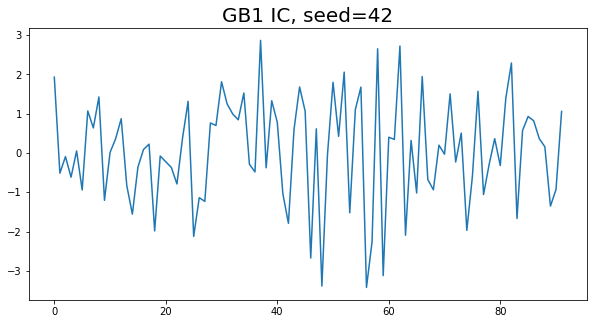

In [20]:
# plot the IC
plt.figure(figsize=(10, 5))
plt.plot(train_test['IC'])
plt.title("GB1 IC, seed=42", fontsize=20)
plt.show()
plt.close()

# at this stage you need to make sure that your output dataframe has the same format as in the backtesting.ipynb file in order to be able to use the code. Otherwise you need to adapt it. Below is some other useful code for evaluating a portfolio (i.e. a backtest)

In [21]:
# compute the backtest portfolio values indexed at 100 for the plot
train_test.index = pd.to_datetime(train_test["date"].astype("int"), format="%Y%m%d")
train_test = 100 * (1 + train_test["forward return 1m"].shift(1) / 100).cumprod()
train_test.iloc[0] = 100
train_test

date
2014-12-31    100.000000
2015-01-30    104.049123
2015-02-27    102.033609
2015-03-31    100.613345
2015-04-30     98.185930
                 ...    
2022-03-31    106.315290
2022-04-29    104.450033
2022-05-31    107.599725
2022-06-30    106.468936
2022-07-29    101.519171
Name: forward return 1m, Length: 92, dtype: float64

In [26]:
def ptfo_metrics(backtest):
    
    monthly_returns = backtest.pct_change(1)
    monthly_returns = monthly_returns.dropna()
    cumulative_return =((monthly_returns+1).cumprod()-1)
    annualized_return = ((1+cumulative_return[-1])**(12/len(backtest)))-1
    
    cum_returns = np.array(backtest) / backtest[0]
    peak = np.maximum.accumulate(cum_returns)
    drawdown = (peak - cum_returns) / peak
    mdd = np.max(drawdown)
    
    colmar = annualized_return/mdd
    volatility = monthly_returns.std() * np.sqrt(12) * 100
    sharpe = (annualized_return*100)/volatility
    return print(
        ' cumulative return:', round(cumulative_return[-1]*100,2),
        '\n',
        'annualized return:', round(annualized_return*100,2),
        '\n',
        'volatility:', round(volatility,2),
        '\n',
        'mdd:', round(mdd*100,2),
        '\n', 
        'sharpe:', round(sharpe,2),
        '\n', 
        'colmar:', round(colmar,2)
    )

In [27]:
# financial evaluation
ptfo_metrics(train_test)

 cumulative return: 1.52 
 annualized return: 0.2 
 volatility: 13.59 
 mdd: 24.91 
 sharpe: 0.01 
 colmar: 0.01


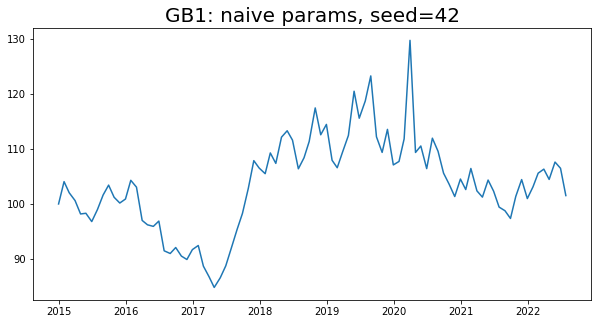

In [28]:
# plot the backtest of the long
plt.figure(figsize=(10, 5))
plt.plot(train_test)
plt.title("GB1: naive params, seed=42", fontsize=20)
plt.show()
plt.close()

# END